<a href="https://colab.research.google.com/github/unica-ml/ml/blob/master/notebooks/lab04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning - Lab04

## Preparation

We import here some utility functions from previous labs, and prepare loaders for the two-moon and MNIST digit data.

In [0]:
import numpy as np

from sklearn import svm
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_moons

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import tensorflow as tf


def plot_dataset(x, y, feat0=0, feat1=1):
    colors = ['b.', 'r.', 'g.', 'k.', 'c.', 'm.']
    class_labels = np.unique(y).astype(int)
    for k in class_labels:
        plt.plot(x[y == k, feat0], x[y == k, feat1], colors[k % 7])


def plot_decision_regions(x, y, classifier, resolution=1e-3):
    # setup marker generator and color map
    colors = ('blue', 'red', 'lightgreen', 'black', 'cyan', 'magenta')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = x[:, 0].min() - 0.02, x[:, 0].max() + 0.02
    x2_min, x2_max = x[:, 1].min() - 0.02, x[:, 1].max() + 0.02
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())


def load_mnist(n_samples, tr=False):
    if tr:
        # load mnist training (60,000 samples)
        (x, y), _ = tf.keras.datasets.mnist.load_data()  
    else:
        # load mnist test (10,000 samples)
        _, (x, y) = tf.keras.datasets.mnist.load_data() 
    # print(x.shape, y.shape)
    # let's reshape and subsample to the first 500 digits
    x = x.reshape(x.shape[0], 784)  # flatten each digit as a row
    x = x[:n_samples, :]  # take the first n_samples digits
    y = y[:n_samples]
    return x, y


def plot_digits(x, y, n=10):
    for i in range(n**2):
        plt.subplot(n,n,i+1)
        plt.imshow(x[i].reshape(28,28), cmap='Greys')
        plt.axis('off')



We now scatter the two-moon data and plot some MNIST digits.

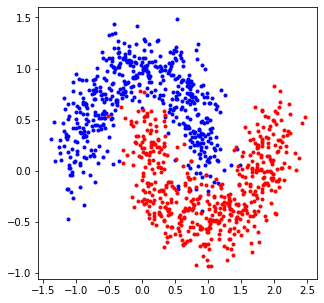

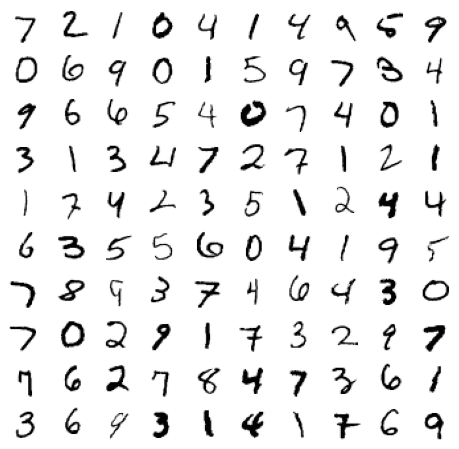

In [26]:
# sample data
x, y = make_moons(n_samples=1000, noise=0.2)
plt.figure(figsize=(5,5))
plot_dataset(x,y)
plt.show()

x, y = load_mnist(n_samples=1000)
plt.figure(figsize=(8,8))
plot_digits(x,y)
plt.show()

## Exercise 1 - Performance Evaluation

In [27]:
x, y = make_moons(n_samples=1000, noise=0.2)

splitter = ShuffleSplit(n_splits=5, random_state=0, train_size=0.5)

scaler = MinMaxScaler()
clf = svm.SVC(kernel='rbf', C=10, gamma=10.0)      
clf_name = 'SVM RBF'

for tr_idx, ts_idx in splitter.split(x, y):
    xtr = x[tr_idx, :]
    ytr = y[tr_idx]
    xts = x[ts_idx, :]
    yts = y[ts_idx]

    xtr = scaler.fit_transform(xtr)
    xts = scaler.transform(xts)

    clf.fit(xtr, ytr)
    ypred = clf.predict(xts)
    error = (ypred != yts).mean()
    print("Test error: {:.1%}".format(error))

Test error: 4.0%
Test error: 4.6%
Test error: 3.6%
Test error: 2.4%
Test error: 4.2%


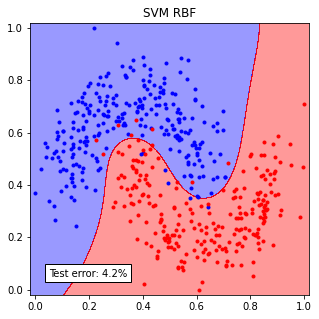

In [28]:
# plot the last classifier
plt.figure(figsize=(5,5))
plt.title(clf_name)
plot_decision_regions(xtr, ytr, clf)
plot_dataset(xtr, ytr)
plt.text(0.05, 0.05, "Test error: {:.1%}".format(error), 
        bbox=dict(facecolor='white'))
plt.show()

Now, let's code this procedure as a function `run`.

In [29]:
def run(x, y, splitter, scaler, clf):
    """Take input data (x,y), split it (n times), scale it, 
    learn classifier on training data, and evaluate the mean test error.
    """
    acc = np.zeros(shape=(splitter.get_n_splits(),))

    for i, (tr_idx, ts_idx) in enumerate(splitter.split(x, y)):
        xtr = x[tr_idx, :]
        ytr = y[tr_idx]
        xts = x[ts_idx, :]
        yts = y[ts_idx]

        xtr = scaler.fit_transform(xtr)
        xts = scaler.transform(xts)

        clf.fit(xtr, ytr)
        ypred = clf.predict(xts)
        acc[i] = (ypred == yts).mean()    
    return acc


# sample data
x, y = make_moons(n_samples=1000, noise=0.2)

splitter = ShuffleSplit(n_splits=10, random_state=0, train_size=0.5)

scaler = MinMaxScaler()
clf = svm.SVC(kernel='linear', C=1)      
acc = run(x, y, splitter, scaler, clf)
print("Mean test accuracy: {:.1%} +/- {:.1%}".format(acc.mean(), 2*acc.std()))
print("Mean test error: {:.1%} +/- {:.1%}".format(1-acc.mean(), 2*acc.std()))


Mean test accuracy: 86.3% +/- 2.7%
Mean test error: 13.7% +/- 2.7%


Let's test it on the MNIST digit data.

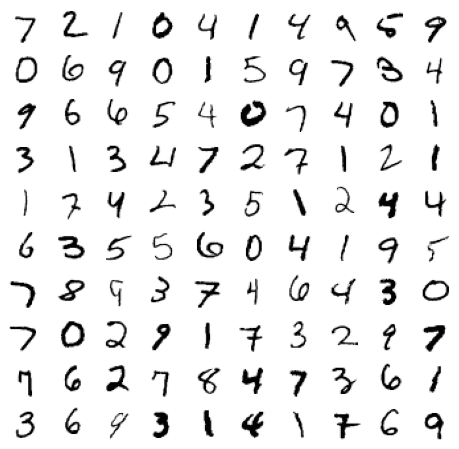

Mean test accuracy: 83.5% +/- 4.3%



In [30]:
x, y = load_mnist(n_samples=500)
plt.figure(figsize=(8,8))
plot_digits(x,y)
plt.show()

clf = svm.SVC(kernel='linear')

acc = run(x, y, splitter, scaler, clf)
print("Mean test accuracy: {:.1%} +/- {:.1%}\n".format(acc.mean(), 2*acc.std()))

## Exercise 2 - Hyperparameter Estimation

Optimize the classifier hyperparameters by performing a grid search with 5-fold cross validation. 

You can use a linear SVM and tune the hyperparameter `C` using  the values:`[0.01, 0.1, 1, 10, 100]`.

For each `C` value,  we have to compute the mean validation accuracy (averaged on the 5 folds). Then, we will select the `C` value corresponding to the maximum mean validation accuracy, and use that value to train our classifier on the whole training set. 

This procedure is already implemented by the `GridSearchCV` wrapper class from sklearn, and we will use it along with our `run` function. 

See:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Let's start by solving the exercise with the `make_moons` dataset.


In [31]:
from sklearn.model_selection import GridSearchCV

# let's go back to the two-moon dataset
x, y = make_moons(n_samples=1000, noise=0.2)

clf = GridSearchCV(estimator=svm.SVC(kernel='linear'), 
                   param_grid={'C': [0.01, 0.1, 1, 10, 100]})

acc = run(x, y, splitter, scaler, clf)

print("Hyperparameter estimation (5-fold xval)")
print("    - Best parameters set found on development set:", clf.best_params_)
print("    - Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("        %0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

print("Mean test accuracy: {:.1%} +/- {:.1%}\n".format(acc.mean(), 2*acc.std()))

Hyperparameter estimation (5-fold xval)
    - Best parameters set found on development set: {'C': 1}
    - Grid scores on development set:
        0.510 (+/-0.000) for {'C': 0.01}
        0.842 (+/-0.081) for {'C': 0.1}
        0.858 (+/-0.085) for {'C': 1}
        0.858 (+/-0.082) for {'C': 10}
        0.852 (+/-0.091) for {'C': 100}
Mean test accuracy: 85.3% +/- 1.2%



We can do the same on the MNIST data.

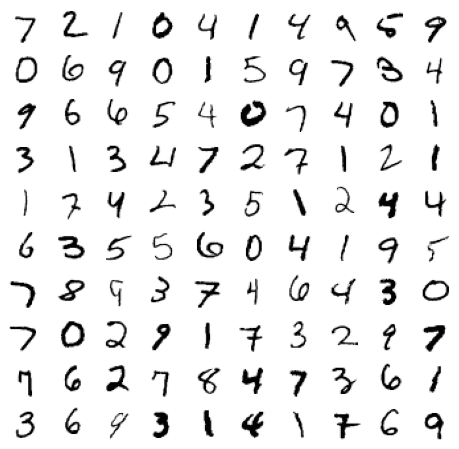

Hyperparameter estimation (5-fold xval)
    - Best parameters set found on development set: {'C': 0.1}
    - Grid scores on development set:
        0.824 (+/-0.039) for {'C': 0.01}
        0.852 (+/-0.090) for {'C': 0.1}
        0.852 (+/-0.090) for {'C': 1}
        0.852 (+/-0.090) for {'C': 10}
        0.852 (+/-0.090) for {'C': 100}
Mean test accuracy: 83.5% +/- 4.3%



In [32]:
from sklearn.model_selection import GridSearchCV

x, y = load_mnist(n_samples=500)
plt.figure(figsize=(8,8))
plot_digits(x,y)
plt.show()

clf = GridSearchCV(estimator=svm.SVC(kernel='linear'), 
                   param_grid={'C': [0.01, 0.1, 1, 10, 100]})

acc = run(x, y, splitter, scaler, clf)

print("Hyperparameter estimation (5-fold xval)")
print("    - Best parameters set found on development set:", clf.best_params_)
print("    - Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("        %0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

print("Mean test accuracy: {:.1%} +/- {:.1%}\n".format(acc.mean(), 2*acc.std()))

## Extras on Hyperparameter Optimization

Hyperparameter optimization can be formalized as a bilevel optimization problem:

$$
\begin{eqnarray}
\min_\gamma && L(\mathcal D_{\rm val}, \theta^\star(\gamma))\\
 {\rm s.t. } && \theta^\star \in {\arg\min}_\theta \mathcal L(\mathcal D_{\rm tr}, \theta, \gamma) 
\end{eqnarray}
 $$

 Let's have a look at the outer objective function (i.e., the validation loss) for an SVM with the RBF kernel, w.r.t. its hyperparameters $C, \gamma$.

C:  [1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]
gamma:  [1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]


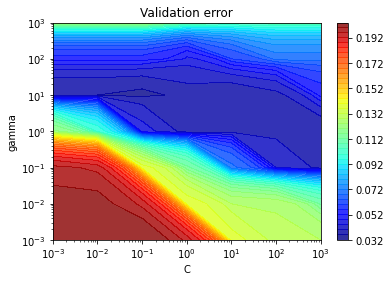

In [35]:
x_tr, y_tr = make_moons(n_samples=1000, noise=0.2)
x_vd, y_vd = make_moons(n_samples=1000, noise=0.2)

C_values = np.logspace(-3, 3, num=7, base=10)
gamma_values= np.logspace(-3, 3, num=7, base=10)

print("C: ", C_values)
print("gamma: ", gamma_values)

clf = svm.SVC(kernel='rbf')

xx1, xx2 = np.meshgrid(C_values, gamma_values)
pairs = np.array([xx1.ravel(), xx2.ravel()]).T
val_loss = np.zeros(shape=(pairs.shape[0],))
# for each possible (C, gamma) pair:
for k, (C, gamma) in enumerate(pairs):
    # print (C, gamma)
    clf.set_params(C=C, gamma=gamma)
    clf.fit(x_tr, y_tr)
    y_pred = clf.predict(x_vd)
    val_loss[k] = (y_pred != y_vd).mean()

Z = val_loss.reshape(xx1.shape)
plt.contourf(xx1, xx2, Z, alpha=0.8, cmap='jet', levels=50)
plt.xlabel('C')
plt.ylabel('gamma')
plt.title('Validation error')
plt.xscale("log") 
plt.yscale("log") 
plt.colorbar()
plt.show()